In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tensorflow

In [3]:
!pip install imgaug

In [4]:
import json
import pandas as pd
import re
import random
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import string
from tqdm import tqdm
import seaborn as sns

import pickle
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import imgaug.augmenters as iaa
import tensorflow as tf
import cv2
from tqdm import tqdm
import os
from keras.layers import Input, Dense, LSTM, Flatten, Dropout, concatenate, Conv1D, MaxPooling2D, Activation, Embedding, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing import image
import PIL
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
import random
from tensorflow.keras.applications import VGG19
from tensorflow.keras.utils import register_keras_serializable

In [5]:
@register_keras_serializable()
def custom_multiply(inputs):
    return inputs[0] * inputs[1]

colab_path = "/content/drive/MyDrive/Hemanth/VQA/Dataset"
tokenizer_50k = pickle.load(open('/content/drive/MyDrive/Hemanth/VQA/model/tokenizer_50k.pkl', 'rb'))
# Load the model with the custom_objects parameter
#model = pickle.load(open('/content/drive/MyDrive/Hemanth/VQA/model/final_model_T5.pkl', 'rb'))
model = tf.keras.models.load_model('/content/drive/MyDrive/Hemanth/VQA/model/model_2lstm_vgg19_50k_T5.h5', custom_objects={'custom_multiply': custom_multiply})  #if using tf.keras
labelencoder = pickle.load(open('/content/drive/MyDrive/Hemanth/VQA/model/labelencoder.pkl', 'rb'))

In [6]:
model = pickle.load(open('/content/drive/MyDrive/Hemanth/VQA/model/final_model_T5.pkl', 'rb'))

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 14 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [16]:
# colab_path = "/content/drive/MyDrive/Hemanth/VQA/Dataset"
# tokenizer_50k = pickle.load(open('/content/drive/MyDrive/Hemanth/VQA/model/tokenizer_50k.pkl', 'rb'))
# model = pickle.load(open('/content/drive/MyDrive/Hemanth/VQA/model/final_model_T5.pkl', 'rb'))
# labelencoder = pickle.load(open('/content/drive/MyDrive/Hemanth/VQA/model/labelencoder.pkl', 'rb'))

def final_function_1(X): # X = [que_text,image_path]

  que_clean_text = text_preprocess(X[0])
  que_vector = pad_sequences(tokenizer_50k.texts_to_sequences([que_clean_text]), maxlen=22, padding='post')

  img = cv2.imread(os.path.join(colab_path,X[1]))
  img = cv2.resize(img,(224,224),interpolation=cv2.INTER_NEAREST)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img_vector = (img/255.0).astype(np.float32)

  predicted_Y = model.predict([que_vector,np.array([img_vector])],verbose=0)
  predicted_class = tf.argmax(predicted_Y, axis=1, output_type=tf.int32)
  predicted_ans = labelencoder.inverse_transform(predicted_class)

  return predicted_ans[0], predicted_Y[0][int(predicted_class)]

def decontractions(phrase):
    """decontracted takes text and convert contractions into natural form.
     ref: https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python/47091490#47091490"""
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"won\’t", "will not", phrase)
    phrase = re.sub(r"can\’t", "can not", phrase)

    phrase = re.sub(r"he\'s", "he is", phrase)
    phrase = re.sub(r"she\'s", "she is", phrase)
    phrase = re.sub(r"it\'s", "it is", phrase)

    phrase = re.sub(r"he\’s", "he is", phrase)
    phrase = re.sub(r"she\’s", "she is", phrase)
    phrase = re.sub(r"it\’s", "it is", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)

    phrase = re.sub(r"n\’t", " not", phrase)
    phrase = re.sub(r"\’re", " are", phrase)
    phrase = re.sub(r"\’d", " would", phrase)
    phrase = re.sub(r"\’ll", " will", phrase)
    phrase = re.sub(r"\’t", " not", phrase)
    phrase = re.sub(r"\’ve", " have", phrase)
    phrase = re.sub(r"\’m", " am", phrase)

    return phrase

def text_preprocess(text):
    text = text.lower()
    text = decontractions(text) # replace contractions into natural form
    text = re.sub('[-,:]', ' ', text) # replace the character "-" "," with space
    text = re.sub("(?!<=\d)(\.)(?!\d)", '', text) # remove the character ".", except from floating numbers
    text = re.sub('[^A-Za-z0-9. ]+', '', text) # remove all punctuation, except A-Za-z0-9
    text = re.sub(' +', ' ', text) # remove extra space
    return text

def text_preprocess_ans(text):
    text = text.lower()
    text = decontractions(text) # replace contractions into natural form
    text = re.sub('[-,:]', ' ', text) # replace the character "-" "," with space
    text = re.sub("(?!<=\d)(\.)(?!\d)", '', text) # remove the character ".", except from floating numbers
    text = re.sub('[^A-Za-z0-9.! ]+', '', text) # remove all punctuation, except A-Za-z0-9
    text = re.sub(' +', ' ', text) # remove extra space
    return text

In [8]:
X_test,y_test = pickle.load(open('/content/drive/MyDrive/Hemanth/VQA/model/test_50k_0711.pkl', 'rb'))

In [15]:
def final_function_2(X): # X = [que_text,image_path]

  que_clean_text = text_preprocess(X[0])
  que_vector = pad_sequences(tokenizer_50k.texts_to_sequences([que_clean_text]), maxlen=22, padding='post')

  img = cv2.imread(os.path.join(colab_path,X[1]))
  img = cv2.resize(img,(224,224),interpolation=cv2.INTER_NEAREST)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img_vector = (img/255.0).astype(np.float32)

  predicted_Y = model.predict([que_vector,np.array([img_vector])],verbose=0)
  # Get indices of top 2 predictions
  top_indices = np.argpartition(predicted_Y[0], -2)[-2:]
  # Sort indices in descending order to get the highest probability first
  top_indices = top_indices[np.argsort(predicted_Y[0][top_indices])[::-1]]

  # Get predicted answers and probabilities for top 2 predictions
  predicted_ans_1 = labelencoder.inverse_transform([top_indices[0]])[0]
  predicted_ans_2 = labelencoder.inverse_transform([top_indices[1]])[0]
  prob_ans_1 = predicted_Y[0][top_indices[0]]
  prob_ans_2 = predicted_Y[0][top_indices[1]]


  return predicted_ans_1, prob_ans_1, predicted_ans_2, prob_ans_2

Input: ['what color is the plate', 'train2014/COCO_train2014_000000278467.jpg']


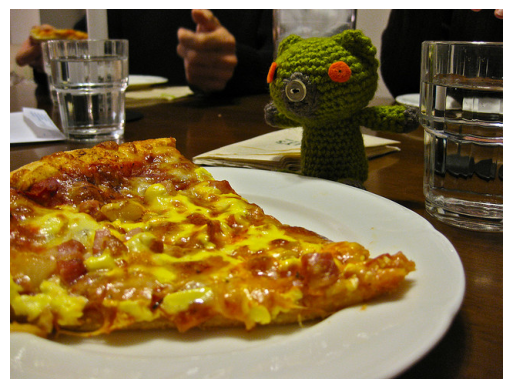

Actual Answer: white
Predicted Answer: white
Predicted Probability: 0.25715765


In [18]:
X = [list(X_test['question_preprocessed'])[5], list(X_test['image_id'])[5]]
print("Input:",X)
img_path = os.path.join(colab_path,list(X_test['image_id'])[5])
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img); plt.axis('off'); plt.show()
print("Actual Answer:",labelencoder.inverse_transform([list(y_test)[5]])[0])
predicted_ans1, prob_ans1 = final_function_1(X)
print("Predicted Answer:",predicted_ans1)
print("Predicted Probability:",prob_ans1)

Input: ['What is that animal?', '/content/drive/MyDrive/Hemanth/VQA/Real-Test-Images/image_1.jpg']


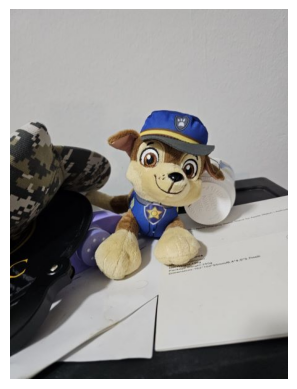

Predicted Answer: dog
Predicted Probability: 0.23419128


In [ ]:
X = ["What is that animal?", '/content/drive/MyDrive/Hemanth/VQA/Real-Test-Images/image_1.jpg']
# "What is that animal? --> dog
#"Is this animal dog?" --> Yes
# "What's on top of head?" --> hat
print("Input:",X)
img_path = X[1]
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img); plt.axis('off'); plt.show()
# print("Actual Answer:",labelencoder.inverse_transform([list(y_test)[5]])[0])
predicted_ans, prob_ans = final_function_1(X)
print("Predicted Answer:",predicted_ans)
print("Predicted Probability:",prob_ans)

Input: ['What is the color of the wood?', '/content/drive/MyDrive/Hemanth/VQA/Real-Test-Images/image_2.jpg']


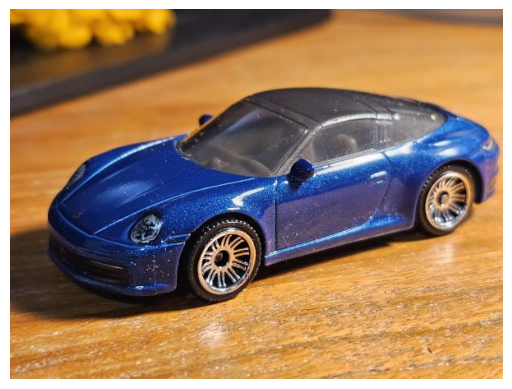

Predicted Answer: brown
Predicted Probability: 0.19924629


In [ ]:
X = ["What is the color of the wood?", '/content/drive/MyDrive/Hemanth/VQA/Real-Test-Images/image_2.jpg']
# "Is that a toy?" --> Yes
# "What color is that car?" --> black (Wrong Prediction)
# "Is that car blue in color?" --> Yes
# "Where is the car?" --> outside (Wrong & Right(probably model might have though as if it is parked))
# "What is the color of the wood?" --> brown
print("Input:",X)
img_path = X[1]
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img); plt.axis('off'); plt.show()
# print("Actual Answer:",labelencoder.inverse_transform([list(y_test)[5]])[0])
predicted_ans, prob_ans = final_function_1(X)
print("Predicted Answer:",predicted_ans)
print("Predicted Probability:",prob_ans)

Input: ['What is there?', '/content/drive/MyDrive/Hemanth/VQA/Real-Test-Images/image_4.jpg']


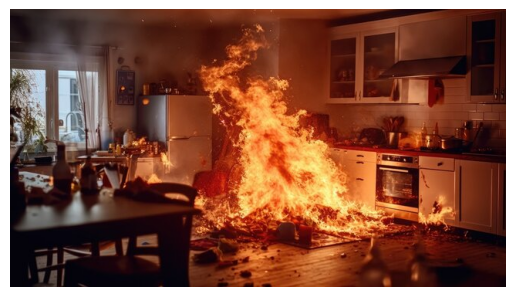

Predicted Answer: kitchen
Predicted Probability: 0.11659721


In [ ]:
X = ["What is there?", '/content/drive/MyDrive/Hemanth/VQA/Real-Test-Images/image_4.jpg']
print("Input:",X)
img_path = X[1]
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img); plt.axis('off'); plt.show()
# print("Actual Answer:",labelencoder.inverse_transform([list(y_test)[5]])[0])
predicted_ans, prob_ans = final_function_1(X)
print("Predicted Answer:",predicted_ans)
print("Predicted Probability:",prob_ans)

# As professor requested, to see top 2 predictions for test image

Input: ['what color is the plate', 'train2014/COCO_train2014_000000278467.jpg']


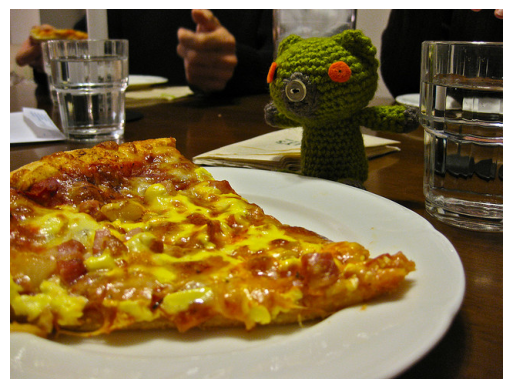

Actual Answer: white
Predicted Answer: ['white', 'brown']
Predicted Probability: [0.25715765, 0.14296451]


In [19]:
X = [list(X_test['question_preprocessed'])[5], list(X_test['image_id'])[5]]
print("Input:",X)
img_path = os.path.join(colab_path,list(X_test['image_id'])[5])
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img); plt.axis('off'); plt.show()
print("Actual Answer:",labelencoder.inverse_transform([list(y_test)[5]])[0])
predicted_ans1, prob_ans1,predicted_ans2, prob_ans2 = final_function_2(X)
print("Predicted Answer:",[predicted_ans1, predicted_ans2])
print("Predicted Probability:",[prob_ans1, prob_ans2])

Input: ['What is that animal?', '/content/drive/MyDrive/Hemanth/VQA/Real-Test-Images/image_1.jpg']


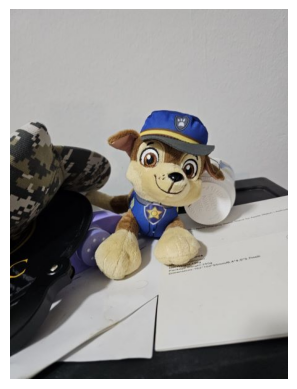

Actual Answer: white
Predicted Answer: ['dog', 'cat']
Predicted Probability: [0.2340391, 0.19969998]


In [21]:
X = ["What is that animal?", '/content/drive/MyDrive/Hemanth/VQA/Real-Test-Images/image_1.jpg']
print("Input:",X)
img_path = X[1]
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img); plt.axis('off'); plt.show()
print("Actual Answer:",labelencoder.inverse_transform([list(y_test)[5]])[0])
predicted_ans1, prob_ans1,predicted_ans2, prob_ans2 = final_function_2(X)
print("Predicted Answer:",[predicted_ans1, predicted_ans2])
print("Predicted Probability:",[prob_ans1, prob_ans2])

Input: ['What is the color of the wood?', '/content/drive/MyDrive/Hemanth/VQA/Real-Test-Images/image_2.jpg']


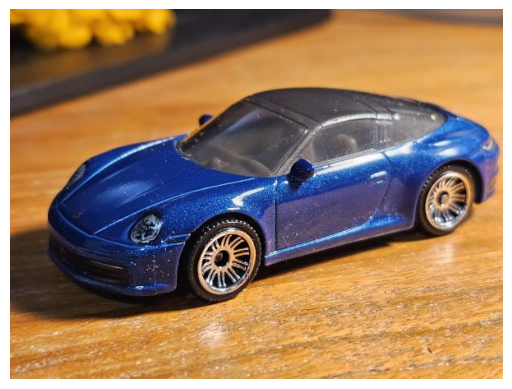

Actual Answer: white
Predicted Answer: ['brown', 'black']
Predicted Probability: [0.19939761, 0.13654634]


In [22]:
X = ["What is the color of the wood?", '/content/drive/MyDrive/Hemanth/VQA/Real-Test-Images/image_2.jpg']
print("Input:",X)
img_path = X[1]
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img); plt.axis('off'); plt.show()
print("Actual Answer:",labelencoder.inverse_transform([list(y_test)[5]])[0])
predicted_ans1, prob_ans1,predicted_ans2, prob_ans2 = final_function_2(X)
print("Predicted Answer:",[predicted_ans1, predicted_ans2])
print("Predicted Probability:",[prob_ans1, prob_ans2])